In [4]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing

np.random.seed(1234)

In [56]:
# Adjacency matrix (undirected graph with self-loops)
N = 4
upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A = upper_triangular + upper_triangular.T
np.fill_diagonal(A, np.random.randint(0, 2, size=N))

upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A_obs = upper_triangular + upper_triangular.T
np.fill_diagonal(A_obs, np.random.randint(0, 2, size=N))

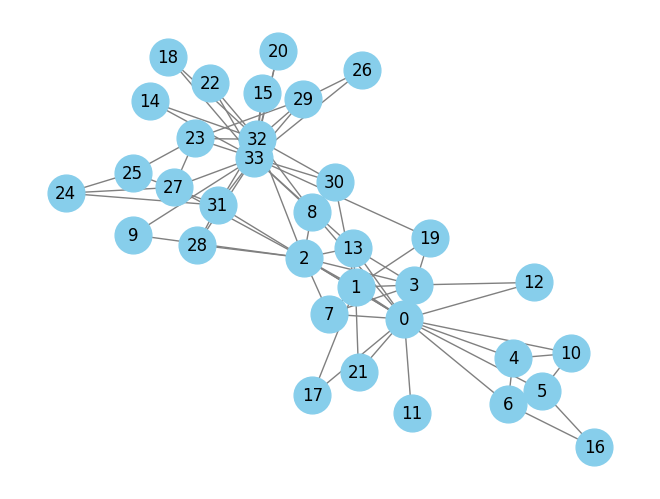

In [42]:
# Get the Karate Club network
G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

In [57]:
# Groups data structure: list of lists
groups = [[] for _ in range(N)]

# Uniformly random initialization
for i in range(N): 
    g = np.random.randint(0, N)
    groups[g].append(i)

In [58]:
A

array([[0, 1, 1, 0],
       [1, 1, 0, 1],
       [1, 0, 1, 1],
       [0, 1, 1, 0]])

In [59]:
groups

[[0, 2], [], [3], [1]]

In [60]:
def linksBetween(A, groups, g1, g2):
    """
    Compute the number of links between two groups
    """
    l = 0
    for i in groups[g1]:
        for j in groups[g2]:
            l += A[i, j]
    return l


def maxBetween(groups, g1, g2):
    """
    Compute the maximum number of links between two groups
    """
    return len(groups[g1]) * len(groups[g2])


def hamiltonian(A, groups):
    """
    Compute the Hamiltonian of the system
    """
    def h(A, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A, groups, g1, g2)
        return np.log(r+1) + np.log(binom(r, l)+1)
            
    H = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            H += h(A, groups, g1, g2)
    
    return H


def findGroup(groups, i):
    """
    Find the group of a given node
    """
    for g, group in enumerate(groups):
        if i in group:
            return g
    
    return None


def swap(groups, i, g_new):
    """
    Swap a node i from group to group g
    """
    # Copy the groups data structure
    new_groups = copy.deepcopy(groups)
    
    # Swap the node
    g_old = findGroup(groups, i)
    new_groups[g_old].remove(i)
    new_groups[g_new].append(i)

    return new_groups


def singleStep(groups, H, A):
    """
    Perform a single step of the Metropolis-Hastings algorithm
    """
    # Randomly select a node and a group
    i = np.random.randint(0, N)
    g_prop = np.random.randint(0, N)

    # Move the node to another group
    groups_prop = swap(groups, i, g_prop)
    
    # Compute the Hamiltonian of the new configuration
    H_prop = hamiltonian(A, groups_prop)

    # Acceptance probability
    if H_prop <= H:
        groups = groups_prop
        H = H_prop
    else:
        r = np.random.rand()
        if r < np.exp(H - H_prop):
            groups = groups_prop
            H = H_prop

    return groups, H


def singleLinkReliability(A, groups, i, j, H=None, return_H=False):
    """
    Reliability of a given link for a particular configuration
    """
    g_i = findGroup(groups, i)
    g_j = findGroup(groups, j)

    r = maxBetween(groups, g_i, g_j)
    l = linksBetween(A, groups, g_i, g_j)

    if H is None: H = hamiltonian(A, groups) # Possibly to save computation

    if return_H:
        return (l + 1)*np.exp(-H)/(r + 2), H
    else:
        return (l + 1)*np.exp(-H)/(r + 2)
   

def singleNetworkReliability(A, A_obs, groups, H=None, return_H=False):
    """
    Reliability of the network for a particular configuration
    """
    def exp_element(A, A_obs, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A, groups, g1, g2)
        l_obs = linksBetween(A_obs, groups, g1, g2)

        t1 = (r+1)/(2*r+1)
        t2 = binom(r, l_obs)/binom(2*r, l+l_obs)

        return np.log(t1) + np.log(t2)

    if H is None: H = hamiltonian(A, groups)

    sum_h = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            sum_h += exp_element(A, A_obs, groups, g1, g2)
          
    h = np.exp(sum_h)

    if return_H:
        return h*np.exp(-H), H
    else:
        return h*np.exp(-H)


def samplingBranch(A, groups, n_samples, delay, seed, return_H=False):
    """
    Sampling algorithm (at equilibrium) to parallelize the computation
    """
    np.random.seed(seed)
    

    partions_set = []
    hamiltonians_list = []

    H = hamiltonian(A, groups)

    for k in range(n_samples):
        for _ in range(delay):
            groups, H = singleStep(groups, H, A)
        partions_set.append(groups)
        hamiltonians_list.append(H)

    if return_H:
        return partions_set, hamiltonians_list
    else:
        return partions_set

In [61]:
H = hamiltonian(A, groups)

transient_history = [H]

# Transient
transient = 5000
for k in tqdm(range(transient)):
    groups, H = singleStep(groups, H, A)

    transient_history.append(H)

  0%|          | 0/5000 [00:00<?, ?it/s]

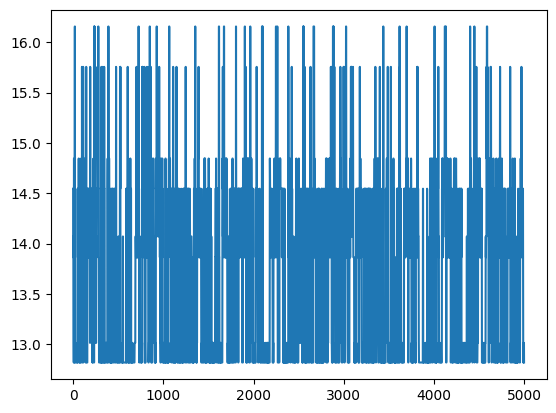

In [62]:
plt.plot(transient_history)

In [63]:
def getPartitionsSet(A, groups_init, n_samples, delay, n_cores=-1, return_H=True):
    """
    Get the set of partitions after the transient
    """
    if n_cores == -1:
       n_cores = multiprocessing.cpu_count()
    
    n_samples_per_core = n_samples//n_cores
    if (n_samples_per_core*n_cores < n_samples):
        print("Warning: n_samples is not a multiple of n_cores, computing ", n_samples_per_core*n_cores, " samples instead.")

    seeds = np.random.randint(0, 2**32-1, n_cores) # Random seeds to avoid the same partitions
    input = [(A, groups_init, n_samples_per_core, delay, seeds[i], return_H) for i in range(n_cores)]

    with multiprocessing.Pool(processes=n_cores) as pool:
        results = pool.starmap(samplingBranch, input)

    if return_H:
        partions_set = [item for sublist in [results[i][0] for i in range(n_cores)] for item in sublist]
        hamiltonians_list = [item for sublist in [results[i][1] for i in range(n_cores)] for item in sublist]
        return partions_set, hamiltonians_list
    else:
        partions_set = [item for sublist in results for item in sublist]
        return partions_set

In [64]:
# # Equilibrium (not in parallel)
# delay = 50 # for uncorrelate the samples
# n_samples = 20
# partions_set = []

# for k in tqdm(range(n_samples)):
#     for _ in range(delay):
#         groups, H = singleStep(groups, H, A)
#     partions_set.append(groups)

In [65]:
# Equilibrium: get the set of partitions
partions_set, hamiltionian_list = getPartitionsSet(A, groups, n_samples=20, delay=20, n_cores=-1, return_H=True)

In [72]:
def computeLinkReliabilityMatrix(A, partions_set, hamiltionian_list=None):
    """
    Compute the link reliability matrix for a given configuration
    """
    if hamiltionian_list is not None: 
        assert len(partions_set) == len(hamiltionian_list), "partions_set and hamiltionian_list must have the same length"

    N = A.shape[0]
    link_reliability = np.zeros((N, N))
        
    if hamiltionian_list is not None:
        for i in range(N):
            for j in range(i, N):
                for k in range(len(partions_set)):
                    link_reliability[i, j] += singleLinkReliability(A, partions_set[k], i, j, hamiltionian_list[k])
    else:
        hamiltionian_list = []
        for i in range(N):
            for j in range(i, N):
                for k in range(len(partions_set)):
                    l_r, H = singleLinkReliability(A, partions_set[k], i, j, return_H=True)
                    link_reliability[i, j] += l_r
                    hamiltionian_list.append(H)


    # Symmetrize the matrix
    link_reliability = link_reliability + link_reliability.T - np.diag(np.diag(link_reliability))

    # Compute the partition function
    Z = np.sum(np.exp(-np.array(hamiltionian_list)))

    return link_reliability / Z


def getLinkLists(A):
    """
    Get the list of links and not links from the adjacency matrix
    """
    links = []
    not_links = []

    for i in range(N):
        for j in range(i, N):
            if A[i, j] == 1:
                links.append((i, j))
            else:
                not_links.append((i, j))

    return links, not_links


def sortLinkLists(links, not_links, link_reliability):
    """
    Sort the lists of links and not links according to their reliability
    """
    # Links: sort by increasing reliability
    links = sorted(links, key=lambda x: link_reliability[x[0], x[1]], reverse=False)
    # Not links: sort by decreasing reliability
    not_links = sorted(not_links, key=lambda x: link_reliability[x[0], x[1]], reverse=True)

    return links, not_links

In [73]:
def getNetworkReliability(A, A_obs, partions_set, hamiltionian_list=None):
    """
    Compute the network reliability
    """
    if hamiltionian_list is not None: 
        assert len(partions_set) == len(hamiltionian_list), "partions_set and hamiltionian_list must have the same length"

    network_reliability = 0

    if hamiltionian_list is not None:
        for k in range(len(partions_set)):
            network_reliability += singleNetworkReliability(A, A_obs, partions_set[k], hamiltionian_list[k])
    else:
        hamiltionian_list = []
        for k in range(len(partions_set)):
            n_r, H = singleNetworkReliability(A, A_obs, partions_set[k], return_H=True)
            network_reliability += n_r
            hamiltionian_list.append(H)

    Z = np.sum(np.exp(-np.array(hamiltionian_list)))
    return network_reliability / Z

In [74]:
#
R_L = computeLinkReliabilityMatrix(A, partions_set, hamiltionian_list)
sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A), R_L)

In [75]:
R_L

array([[0.25710909, 0.71899254, 0.71119329, 0.24307626],
       [0.71899254, 0.65960379, 0.36319243, 0.71093034],
       [0.71119329, 0.36319243, 0.66018811, 0.71925548],
       [0.24307626, 0.71093034, 0.71925548, 0.24098469]])

In [ ]:
# Iterate to reconstruct the network

for k in range(np.min(len(sorted_links), len(sorted_not_links))):
    